In [1]:
%matplotlib inline
import ipyplot
import matplotlib.pyplot as plt

# Training SSD

## Imports and defaults

In [2]:
import json
import os
import sys
import cv2
import numpy as np

from mmdet.apis import init_detector, inference_detector
import mmcv

log_filepath = "checkpoints/20210924_224805.log.json"
mmdet_ssd_config_dir = "/home/phd/09/igor/mmdetection/configs/ssd/"
mmdet_ssd_config_filename = "ssd512_sportradar.py"

frames_dir = os.path.join("data","frames")
frame_ids = [0,500,600*25]

## MMDetection

```MMDetection is an open source object detection toolbox based on PyTorch. It is a part of the OpenMMLab project.```
[https://github.com/open-mmlab/mmdetection](https://github.com/open-mmlab/mmdetection)

## Object detector for scoreboard detection (SSD)

## SSD Config file

``` 
_base_ = 'ssd300_coco.py'
input_size = 512
model = dict(
    backbone=dict(input_size=input_size),
    bbox_head=dict(
        in_channels=(512, 1024, 512, 256, 256, 256, 256),
        anchor_generator=dict(
            type='SSDAnchorGenerator',
            scale_major=False,
            input_size=input_size,
            basesize_ratio_range=(0.1, 0.9),
            strides=[8, 16, 32, 64, 128, 256, 512],
            ratios=[[2], [2, 3], [2, 3], [2, 3], [2, 3], [2], [2]])))
# dataset settings
dataset_type = 'SportradarDataset'
data_root = '/tmp2/igor/tennis-SR/data/'
img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[1, 1, 1], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile', to_float32=True),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='PhotoMetricDistortion',
        brightness_delta=32,
        contrast_range=(0.5, 1.5),
        saturation_range=(0.5, 1.5),
        hue_delta=18),
    dict(
        type='Expand',
        mean=img_norm_cfg['mean'],
        to_rgb=img_norm_cfg['to_rgb'],
        ratio_range=(1, 4)),
    # dict(
    #     type='MinIoURandomCrop',
    #     min_ious=(0.1, 0.3, 0.5, 0.7, 0.9),
    #     min_crop_size=0.3),
    dict(type='Resize', img_scale=(512, 512), keep_ratio=False),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='RandomFlip', flip_ratio=0.),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=False),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]
data = dict(
    samples_per_gpu=16,
    workers_per_gpu=3,
    train=dict(
        _delete_=True,
        type='RepeatDataset',
        times=1,
        dataset=dict(
            type=dataset_type,
            ann_file=data_root + 'top-100-shots-rallies-2018-atp-season-scoreboard-annotations_coco_train.json',
            img_prefix=data_root + 'frames/',
            pipeline=train_pipeline)),
    val=dict(pipeline=test_pipeline, 
        type=dataset_type,
        img_prefix=data_root + 'frames/',
        ann_file=data_root + 'top-100-shots-rallies-2018-atp-season-scoreboard-annotations_coco_val.json'),
    test=dict(pipeline=test_pipeline,
        type=dataset_type,
        img_prefix=data_root + 'frames/',
        ann_file=data_root + 'top-100-shots-rallies-2018-atp-season-scoreboard-annotations_coco_test.json'))
custom_hooks = []
# optimizer
optimizer = dict(type='SGD', lr=2e-3, momentum=0.9, weight_decay=5e-4)
optimizer_config = dict(_delete_=True)
```

## Read results from JSON file and plot

In [3]:
with open(log_filepath, "r") as f:
    log_txt = "["+",".join(f.read().splitlines())+"]"
log = json.loads(log_txt)

In [4]:
train_data = {key : [] for key in ["epoch","iter","lr","loss_cls", "loss_bbox", "loss"]}
val_data = {key : [] for key in ["epoch","iter","bbox_mAP", "bbox_mAP_50", "bbox_mAP_75"]}
for entry in log:
    if "mode" not in entry.keys():
        continue
    mode = entry["mode"]
    if mode != "train" and mode != "val":
        continue
    if mode == "train":
        for key in train_data.keys():
            if key not in entry.keys(): raise Exception(f"{key} expected in the log entry {entry}")
            train_data[key].append(entry[key])
    if mode == "val":
        for key in val_data.keys():
            if key not in entry.keys(): raise Exception(f"{key} expected in the log entry {entry}")
            val_data[key].append(entry[key])

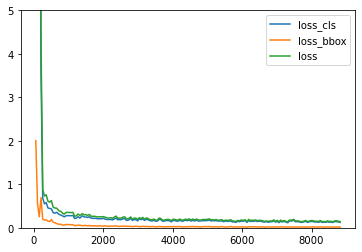

In [5]:
train_iter_n = val_data["iter"][0]
train_iter = [(e-1)*train_iter_n+i for e, i in zip(train_data["epoch"], train_data["iter"])]
val_iter = [(e-1)*train_iter_n+i for e,i in zip(val_data["epoch"], val_data["iter"])]
plt.clf()
for key in ["loss_cls", "loss_bbox", "loss"]:
    x = train_data[key]
    plt.plot(train_iter, x, label=key)
plt.legend()
plt.ylim(0, 5)
plt.show()

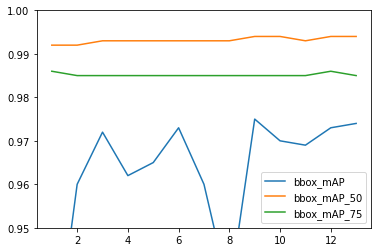

In [6]:
plt.clf()
for key in ["bbox_mAP", "bbox_mAP_50", "bbox_mAP_75"]:
    x = val_data[key]
    plt.plot(val_data["epoch"], x, label=key)
plt.legend()
plt.ylim(0.95, 1)
plt.show()

## Load checkpoint

In [7]:
config_file = os.path.join(mmdet_ssd_config_dir, mmdet_ssd_config_filename)
checkpoint_file = os.path.join("checkpoints","epoch_9.pth")

In [8]:
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

In [9]:
imgs = [cv2.imread(os.path.join(frames_dir,f"{i}.jpg"))[:,:,::-1] for i in frame_ids]
results = inference_detector(model, imgs)

/auto/phd/09/igor/mmdetection/mmdet/datasets/utils.py:60: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


In [16]:
scoreboards = []
for idx, (img, result) in enumerate(zip(imgs, results)):
    x1, y1, x2, y2, score = result[0][np.argmax(result[0][:,4])]    
    x1, y1, x2, y2 = [int(i) for i in [x1, y1, x2, y2]]
    scoreboards.append(img[y1:y2,x1:x2])

/home/phd/09/igor/miniconda3/envs/mmdet/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)



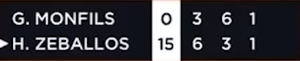
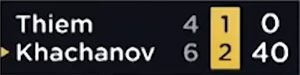
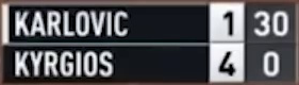


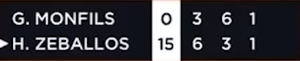
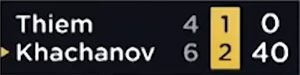
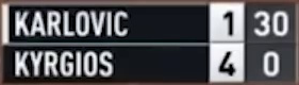

In [17]:
ipyplot.plot_images(scoreboards, max_images=3, img_width=300)